In [4]:
# ============================================================================
# HULL TACTICAL MARKET PREDICTION - EXPLORATORY DATA ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. LOAD DATA
# ============================================================================

train_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (9021, 98)
Test shape: (10, 99)


In [5]:
# ============================================================================
# 2. DATA OVERVIEW
# ============================================================================

# Basic info
print("Column types:")
print(train_df.dtypes.value_counts())
print(f"\nTotal missing values: {train_df.isnull().sum().sum()}")

Column types:
float64    88
int64      10
Name: count, dtype: int64

Total missing values: 137675


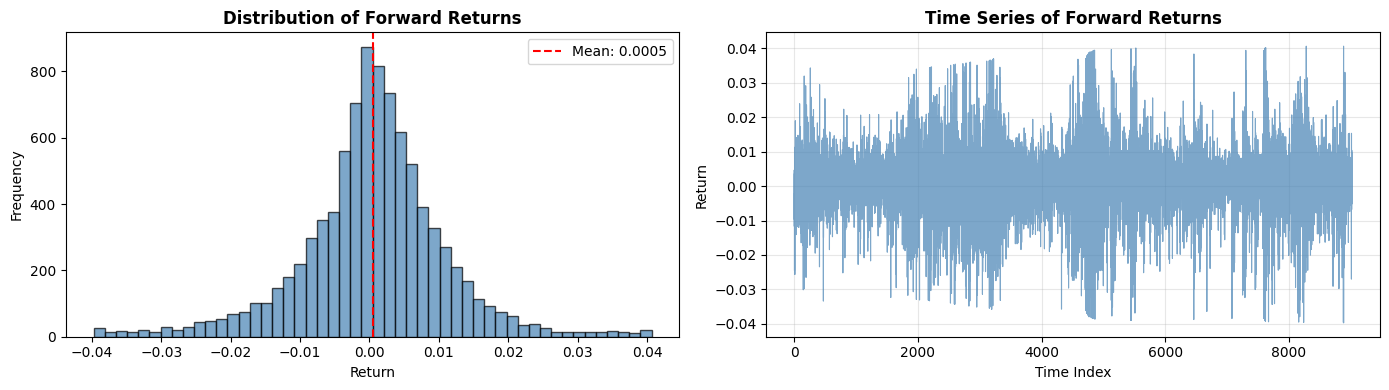


TARGET VARIABLE STATISTICS
Mean:     0.000471
Std Dev:  0.010541
Min:      -0.039754
Max:      0.040661
Skewness: -0.1782
Kurtosis: 2.1979


In [6]:
# ============================================================================
# 3. TARGET VARIABLE ANALYSIS
# ============================================================================

target = 'forward_returns'

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Distribution
axes[0].hist(train_df[target], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution of Forward Returns', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df[target].mean(), color='red', linestyle='--', label=f"Mean: {train_df[target].mean():.4f}")
axes[0].legend()

# Time series
axes[1].plot(train_df[target].values, linewidth=0.8, alpha=0.7, color='steelblue')
axes[1].set_title('Time Series of Forward Returns', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Return')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TARGET VARIABLE STATISTICS")
print("="*60)
print(f"Mean:     {train_df[target].mean():.6f}")
print(f"Std Dev:  {train_df[target].std():.6f}")
print(f"Min:      {train_df[target].min():.6f}")
print(f"Max:      {train_df[target].max():.6f}")
print(f"Skewness: {stats.skew(train_df[target]):.4f}")
print(f"Kurtosis: {stats.kurtosis(train_df[target]):.4f}")

# Forward returns are normally distributed with slight left skew.
# Positive mean (0.047%) suggests upward bias. Standard deviation (1.054%) 
# indicates daily volatility similar to market benchmark.

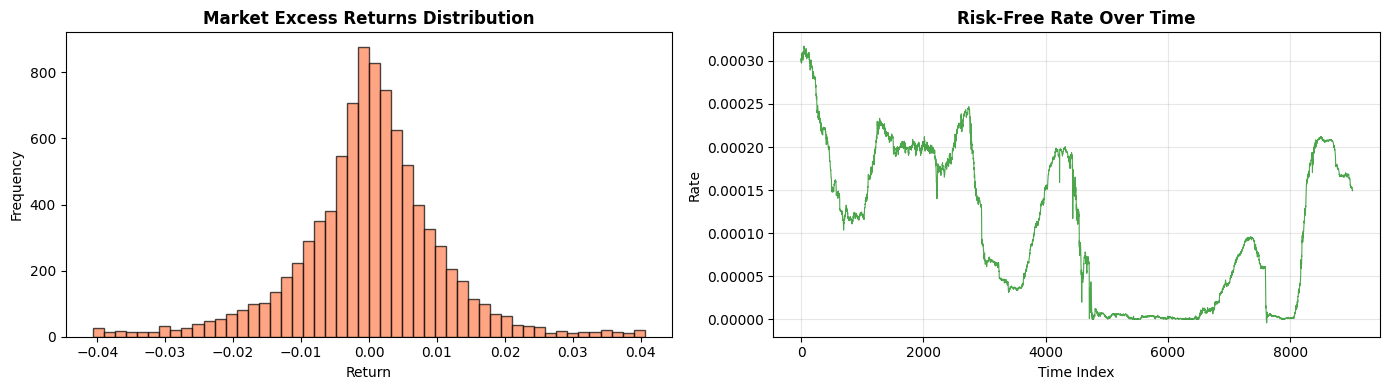


BENCHMARK & RISK-FREE RATE STATISTICS
Market Return Mean:   0.000053
Market Return Std:    0.010558
Risk-Free Rate Mean:  0.000107


In [7]:
# ============================================================================
# 4. BENCHMARK & RISK-FREE RATE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Benchmark returns
market_col = 'market_forward_excess_returns'
axes[0].hist(train_df[market_col], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Market Excess Returns Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')

# Risk-free rate
axes[1].plot(train_df['risk_free_rate'].values, linewidth=0.8, alpha=0.7, color='green')
axes[1].set_title('Risk-Free Rate Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Rate')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("BENCHMARK & RISK-FREE RATE STATISTICS")
print("="*60)
print(f"Market Return Mean:   {train_df[market_col].mean():.6f}")
print(f"Market Return Std:    {train_df[market_col].std():.6f}")
print(f"Risk-Free Rate Mean:  {train_df['risk_free_rate'].mean():.6f}")

# Market benchmark has similar volatility (1.056%) to target.
# Our model must beat this baseline. Risk-free rate is near zero (low interest environment).

In [14]:
# ============================================================================
# 6. MISSING DATA ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing_pct = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
    
print(f"Features with <10% missing: {len(missing_pct[missing_pct < 10])}")
print(f"Features with 10-30% missing: {len(missing_pct[(missing_pct >= 10) & (missing_pct < 30)])}")
print(f"Features with >30% missing: {len(missing_pct[missing_pct >= 30])}")



MISSING VALUES
Features with <10% missing: 0
Features with 10-30% missing: 73
Features with >30% missing: 12



TIME-SERIES CHARACTERISTICS
Total time steps: 9021
Time span: date_id 0 to 9020
Average daily return: 0.000471
Daily volatility: 0.010541


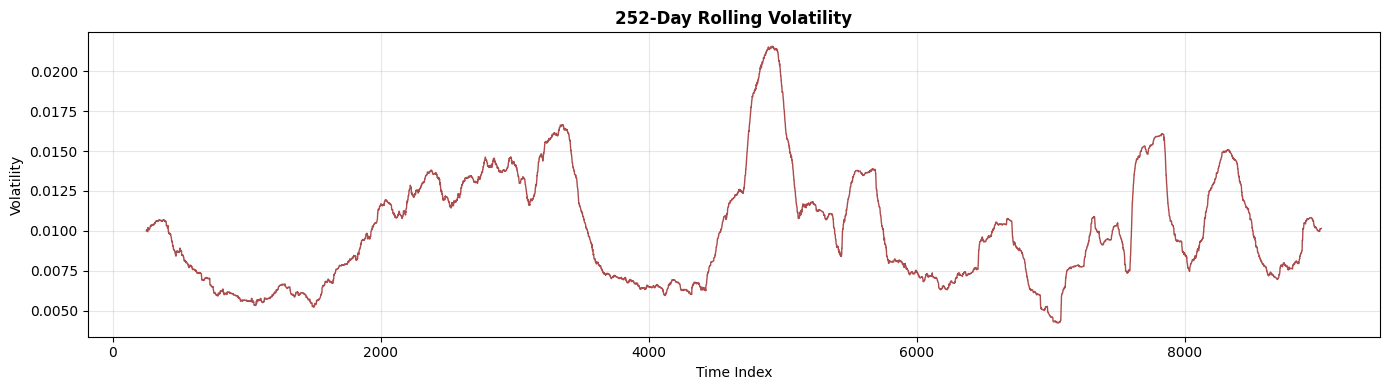

Rolling volatility mean: 0.009983
Rolling volatility range: [0.004240, 0.021566]


In [12]:
# ============================================================================
# 7. TIME-SERIES CHARACTERISTICS
# ============================================================================

print("\n" + "="*60)
print("TIME-SERIES CHARACTERISTICS")
print("="*60)
print(f"Total time steps: {len(train_df)}")
print(f"Time span: date_id {train_df['date_id'].min()} to {train_df['date_id'].max()}")
print(f"Average daily return: {train_df[target].mean():.6f}")
print(f"Daily volatility: {train_df[target].std():.6f}")

# Calculate rolling volatility
rolling_vol = train_df[target].rolling(252).std()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(rolling_vol.values, linewidth=1, alpha=0.7, color='darkred')
ax.set_title('252-Day Rolling Volatility', fontsize=12, fontweight='bold')
ax.set_xlabel('Time Index')
ax.set_ylabel('Volatility')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Rolling volatility mean: {rolling_vol.mean():.6f}")
print(f"Rolling volatility range: [{rolling_vol.min():.6f}, {rolling_vol.max():.6f}]")